This notebook plots the uncertainty partitioning of changes in the number of joint storm surge & precipitation extremesand wind speed & precipitation extremes.

In [1]:
import numpy as np
import xarray as xr
import os
import fnmatch
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%config InlineBackend.figure_format = 'retina'
from globe import is_land

/tmp/ipykernel_1539/570025202.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def preprocess(ds):
    ds = ds.expand_dims(dim={"source_id": [ds.source_id]})
    return ds

Load output of joint probability analysis:

In [3]:
#load wind speed & precipitation
in_dir = '/home/jovyan/CMIP6cex/output/num_extremes/timeseries_eu_1p5/sfcWind_pr/40yr_p98_lag0d_declus1d_ref2000/'
ssps = ['ssp245','ssp585']

ds_fns = [] #get filenames wind & pr
for top, dirs, files in os.walk(in_dir):
    for file in files:
           ds_fns.append(os.path.join(top, file))
            
ds_surge_fns = [] #get filenames surge & pr
for top, dirs, files in os.walk('/home/jovyan/CMIP6cex/output/num_extremes/timeseries_eu_gesla2_tgs/surge_pr/40yr_p98_lag0d_declus1d_ref2000/'):
    for file in files:
           ds_surge_fns.append(os.path.join(top, file))          

#we have more availability for sfcWind than surge (also needs psl), only open the overlapping files here
ssps_ds = []
for ssp in ssps:
    ssp_fns = fnmatch.filter(ds_fns,'*'+ssp+'*')
    ssp_surge_fns = fnmatch.filter(ds_surge_fns,'*'+ssp+'*')
    ssp_fns = [f for f in ssp_fns if '/'.join(f.split('/')[-3::]) in ['/'.join(k.split('/')[-3::]) for k in ssp_surge_fns]]
    ssp_ds = xr.open_mfdataset((ssp_fns),preprocess=preprocess,coords='minimal').chunk({'member_id':200})
    ssps_ds.append(ssp_ds)

numex_ds = xr.concat(ssps_ds,dim='ssp')
numex_ds = numex_ds.assign_coords({'ssp':ssps})

num_joint_wp = numex_ds.num_joint_extremes.load() #load into memory
num_joint_wp_isect = num_joint_wp.where(np.isfinite(num_joint_wp).all(dim=['ssp','latitude','longitude']),drop=True) #get the intersection of members with both SSPs available

In [4]:
#load storm surge & precipitation:
in_dir = '/home/jovyan/CMIP6cex/output/num_extremes/timeseries_eu_gesla2_tgs/surge_pr/40yr_p98_lag0d_declus1d_ref2000/'
ssps = ['ssp245','ssp585']

ds_fns = []
for top, dirs, files in os.walk(in_dir):
    for file in files:
        ds_fns.append(os.path.join(top, file))

ssps_ds = []
for ssp in ssps:
    ssp_fns = fnmatch.filter(ds_fns,'*'+ssp+'*')
    ssp_ds = xr.open_mfdataset((ssp_fns),preprocess=preprocess,coords='minimal').chunk({'member_id':200})
    ssps_ds.append(ssp_ds)
    
numex_ds = xr.concat(ssps_ds,dim='ssp')
numex_ds = numex_ds.assign_coords({'ssp':['ssp245','ssp585']})

num_joint_sp = numex_ds[['num_joint_extremes','num_joint_extremes_pr_driven',
                              'num_joint_extremes_surge_driven','num_joint_extremes_surge_pr_driven']].load()
num_joint_sp_isect = num_joint_sp.where(np.isfinite(num_joint_sp).all(dim=['ssp','tg']),drop=True) #members with both SSPs available

In [5]:
smiles = ['ACCESS-ESM1-5','CanESM5','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','UKESM1-0-LL'] #select large-ensemble models

Compute uncertainty partitioning using SMILEs (see paper):

In [6]:
I_sp = (num_joint_sp_isect.sel(source_id=smiles).sum(dim='month',skipna=False).sel(window=2080)-num_joint_sp_isect.sel(source_id=smiles).sum(dim='month',skipna=False).sel(window=2000)).std(dim='member_id').mean(dim='source_id')
I_wp = (num_joint_wp_isect.sel(source_id=smiles).sum(dim='month',skipna=False).sel(window=2080)-num_joint_wp_isect.sel(source_id=smiles).sum(dim='month',skipna=False).sel(window=2000)).std(dim='member_id').mean(dim='source_id')

M_sp = (num_joint_sp_isect.sel(source_id=smiles).sum(dim='month',skipna=False).sel(window=2080)-num_joint_sp_isect.sel(source_id=smiles).sum(dim='month',skipna=False).sel(window=2000)).mean(dim='member_id').std(dim='source_id')
M_wp = (num_joint_wp_isect.sel(source_id=smiles).sum(dim='month',skipna=False).sel(window=2080)-num_joint_wp_isect.sel(source_id=smiles).sum(dim='month',skipna=False).sel(window=2000)).mean(dim='member_id').std(dim='source_id')

S_sp = (num_joint_sp_isect.sum(dim='month',skipna=False).sel(window=2080)-num_joint_sp_isect.sum(dim='month',skipna=False).sel(window=2000)).mean(dim='member_id').std(dim='ssp').mean(dim='source_id')
S_wp = (num_joint_wp_isect.sum(dim='month',skipna=False).sel(window=2080)-num_joint_wp_isect.sum(dim='month',skipna=False).sel(window=2000)).mean(dim='member_id').std(dim='ssp').mean(dim='source_id')

Plot standard deviations due to different sources of uncertainty:

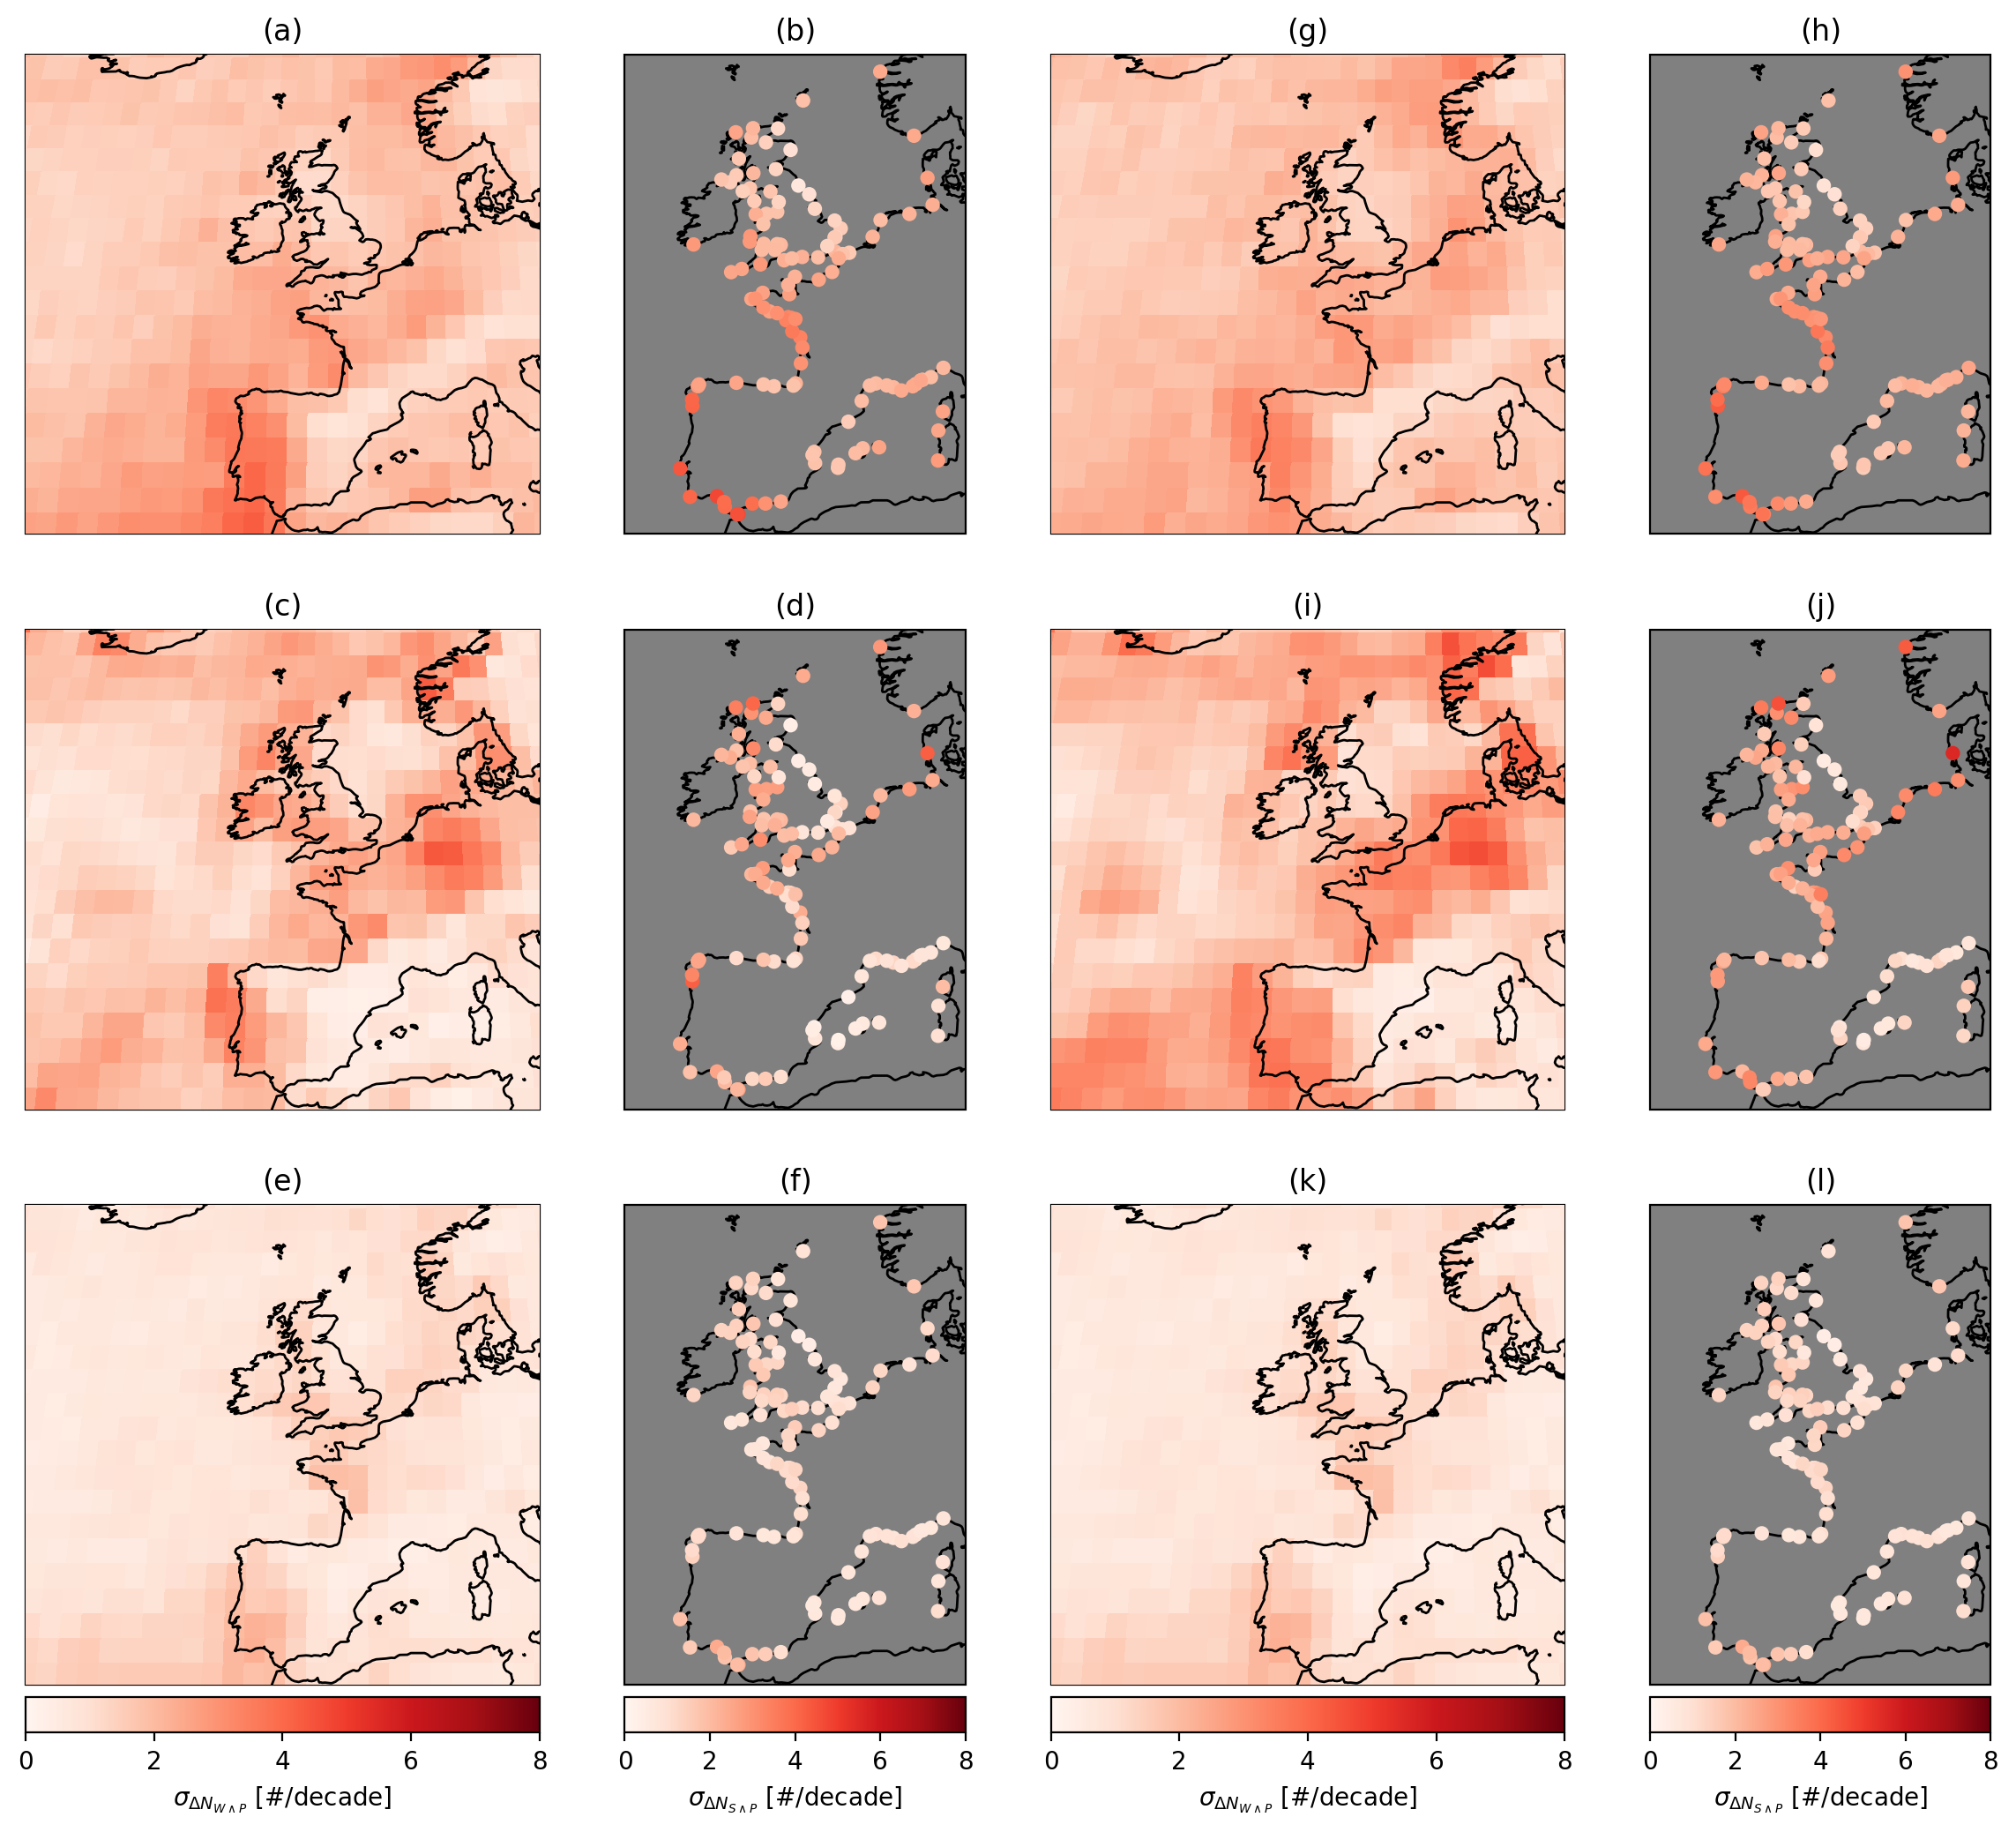

In [7]:
fig=plt.figure(figsize=(15,12)) #generate figure  
gs = fig.add_gridspec(3,6)
gs.update(wspace=.001)

for s,ssp in enumerate(ssps):
    #uncertainty partioning for dN wp
    ax = plt.subplot(gs[0,0+s*3:2+s*3],projection=ccrs.Robinson(central_longitude=0)) #internal variability

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

    sc=(.25*I_wp.sel(ssp=ssp)).plot(cmap='Reds',vmin=0,vmax=8,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())
    
    sc.set_edgecolor('face')
    ax.set_title(['(a)','(g)'][s])
    
    ax = plt.subplot(gs[1,0+s*3:2+s*3],projection=ccrs.Robinson(central_longitude=0)) #model differences

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
    #ax.add_feature(cartopy.feature.BORDERS, zorder=6, facecolor='black')
    
    sc=(.25*M_wp.sel(ssp=ssp)).plot(cmap='Reds',vmin=0,vmax=8,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())
    
    sc.set_edgecolor('face')
    ax.set_title(['(c)','(i)'][s])
    ax = plt.subplot(gs[2,0+s*3:2+s*3],projection=ccrs.Robinson(central_longitude=0)) #scenario

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
    
    sc=(.25*S_wp).plot(cmap='Reds',vmin=0,vmax=8,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
    ax.coastlines(zorder=5)
    ax.set_extent([-24, 13, 35, 65], crs=ccrs.PlateCarree())
    
    cax=ax.inset_axes(bounds=(0, -.1,1,.075))
    cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\sigma_{\Delta N_{W \wedge P}}$ [#/decade]')
    ax.set_title(['(e)','(k)'][s])
    sc.set_edgecolor('face')
    
    
    #uncertainty partioning for dN sp
    ax = plt.subplot(gs[0,2+s*3],projection=ccrs.Robinson(central_longitude=0)) #internal variability

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
    sc=ax.scatter(I_sp.lon,I_sp.lat,c=(.25*I_sp.sel(ssp=ssp)),s=24,cmap='Reds',vmin=0,vmax=8,transform=ccrs.PlateCarree(),zorder=4)
            
    ax.coastlines(zorder=1)
    ax.set_extent([-13, 10, 35, 63], crs=ccrs.PlateCarree())
    
    sc.set_edgecolor('face')
    ax.set_title(['(b)','(h)'][s])
    
    ax = plt.subplot(gs[1,2+s*3],projection=ccrs.Robinson(central_longitude=0)) #model differences

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
    sc=ax.scatter(I_sp.lon,I_sp.lat,c=(.25*M_sp.sel(ssp=ssp)),s=24,cmap='Reds',vmin=0,vmax=8,transform=ccrs.PlateCarree(),zorder=4)
            
    ax.coastlines(zorder=1)
    ax.set_extent([-13, 10, 35, 63], crs=ccrs.PlateCarree())
    
    sc.set_edgecolor('face')
    ax.set_title(['(d)','(j)'][s])
    
    ax = plt.subplot(gs[2,2+s*3],projection=ccrs.Robinson(central_longitude=0)) #scenario

    ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='grey')
    ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
    sc=ax.scatter(I_sp.lon,I_sp.lat,c=(.25*S_sp),s=24,cmap='Reds',vmin=0,vmax=8,transform=ccrs.PlateCarree(),zorder=4)
    #sc=ax.scatter(I_sp.lon,I_sp.lat,c=(S_sp>I_sp.sel(ssp=ssp)),s=20,cmap='Reds',vmin=0,vmax=1,transform=ccrs.PlateCarree(),zorder=4)        
    ax.coastlines(zorder=1)
    ax.set_extent([-13, 10, 35, 63], crs=ccrs.PlateCarree())
    
 
    cax=ax.inset_axes(bounds=(0, -.1,1,.075))
    cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='$\sigma_{\Delta N_{S \wedge P}}$ [#/decade]')
    sc.set_edgecolor('face')
    ax.set_title(['(f)','(l)'][s])
    
#fig.savefig('Figures/dN_unc_partioning.jpg',format='jpg',dpi=300,bbox_inches='tight') #store figure

    